In [110]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from time import time

In [29]:
df = pd.read_csv("average_data.csv")
df = df.drop(df.columns[[0]], axis=1)

In [30]:
df = df.astype({"attacked": int})

In [31]:
xgb_columns = ['vx_sd', 'z_sd', 'init_align', 'yaw', 'roll', 'pitch', 'vu', 've', 'attacked']

In [32]:
df_xgb = df[xgb_columns]

In [33]:
df_xgb

,vx_sd,z_sd,init_align,yaw,roll,pitch,vu,ve,attacked
0,0.000362,0.013414,1.000000,0.283453,0.011166,-0.011591,0.027276,1.030855,1
1,0.000362,0.013414,1.000000,0.283453,0.011167,-0.011591,0.027276,1.030856,1
2,0.000362,0.013412,1.000000,0.283450,0.011144,-0.011635,0.027373,1.030864,1
3,0.000362,0.013414,1.000000,0.283453,0.011167,-0.011590,0.027276,1.030855,1
4,0.000362,0.013414,1.000000,0.283453,0.011167,-0.011591,0.027277,1.030856,1
...,...,...,...,...,...,...,...,...,...
1562,0.000532,0.009988,1.000000,1.123441,-0.005201,-0.015657,-0.033840,-7.027429,1
1563,0.000979,0.010169,1.000000,1.123416,-0.004698,-0.014389,-0.022906,-6.888210,1
1564,0.000506,0.011099,1.000000,1.123528,-0.004400,-0.015081,0.005697,-7.030161,1
1565,0.001085,0.010090,1.000000,1.123460,-0.004089,-0.015760,-0.060297,-7.039860,1


In [34]:
average_data = df_xgb.drop('attacked', axis=1)

df_scaled = StandardScaler().fit_transform(average_data)
scaled_df = pd.DataFrame(df_scaled, columns=average_data.columns)

In [35]:
pca = PCA(n_components=.95).fit(scaled_df)
transformed_df = pca.transform(scaled_df)

print('Original dimensions: ', scaled_df.shape)
print('PCA dimensions: ', transformed_df.shape)

Original dimensions:  (1567, 8)
PCA dimensions:  (1567, 4)


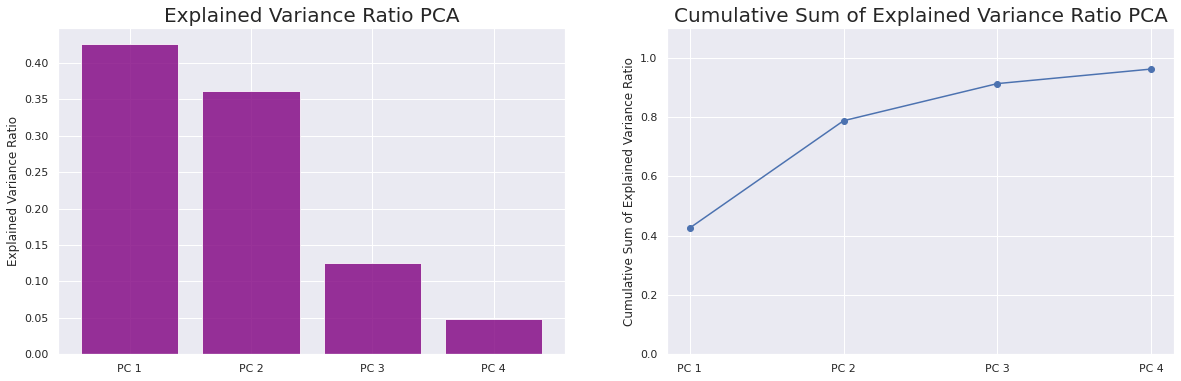

In [36]:
fig, ax = plt.subplots(ncols=2, figsize=(20,6))
ax1, ax2 = ax.ravel()

ratio = pca.explained_variance_ratio_
ax1.bar(range(len(ratio)), ratio, color='purple', alpha=0.8)
ax1.set_title('Explained Variance Ratio PCA', fontsize=20)
ax1.set_xticks(range(len(ratio)))
ax1.set_xticklabels(['PC {}'.format(i+1) for i in range(len(ratio))])
ax1.set_ylabel('Explained Variance Ratio')

# ratio[0]=0
ratio = pca.explained_variance_ratio_
ax2.plot(np.cumsum(ratio), 'o-')

ax2.set_title('Cumulative Sum of Explained Variance Ratio PCA', fontsize=20)

ax2.set_ylim(0,1.1)
ax2.set_xticks(range(len(ratio)))
ax2.set_xticklabels(['PC {}'.format(i+1) for i in range(len(ratio))])
ax2.set_ylabel('Cumulative Sum of Explained Variance Ratio');

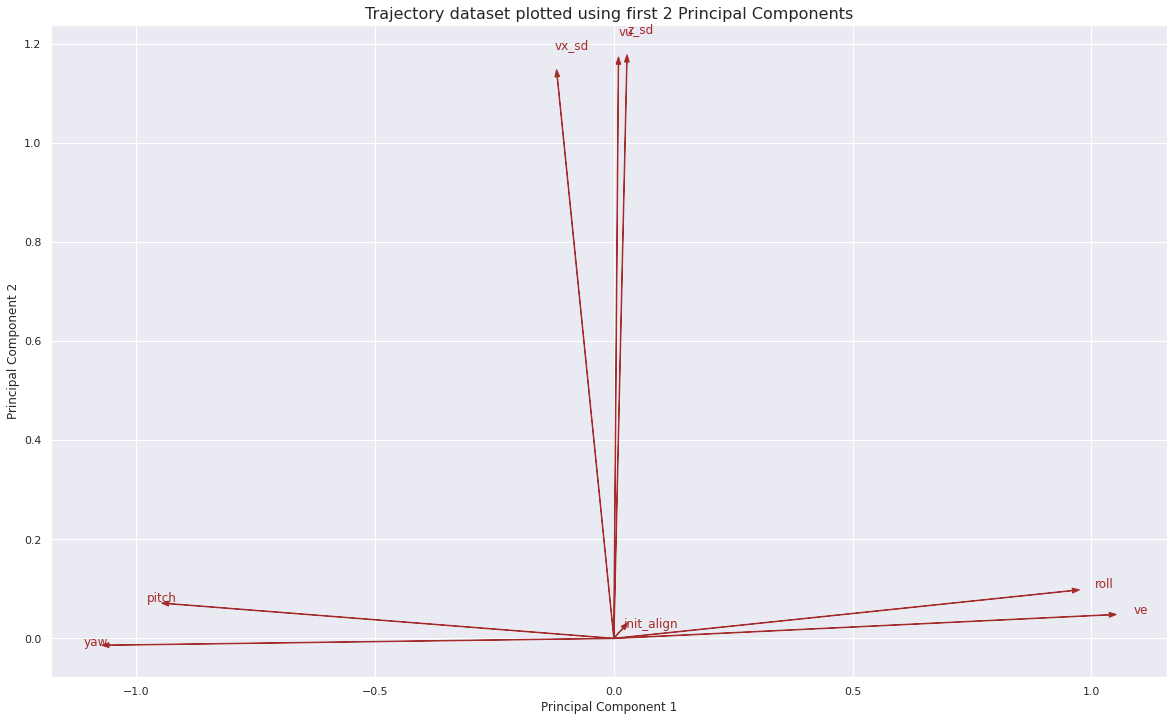

In [37]:
# to plot vectors from the center
vecs = pca.components_[0:8].T *2

fig, ax = plt.subplots(figsize=(20,12))
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Trajectory dataset plotted using first 2 Principal Components', fontsize=16)

# plotting arrowheads of the original axes projected on the 2D PCA space
for i, vec in enumerate(vecs):
    ax.arrow(0,0,vec[0],vec[1], color='brown', head_width=0.01)
    s = 1.05
    ax.annotate(scaled_df.columns[i], (s*vec[0], s*vec[1]), color='brown')

In [93]:
df_attacked = df_xgb[df_xgb['attacked'] == 1]
df_groundtruth = df_xgb[df_xgb['attacked'] == 0]

df_attacked.reset_index(inplace=True)

In [94]:
# Define columns to consider for outlier removal
columns_to_consider = df_attacked.columns[df_attacked.columns != 'attacked']

# Compute z-scores for each column excluding 'attacked'
z_scores = np.abs(stats.zscore(df_attacked[columns_to_consider]))

# Set threshold
threshold_z = 2.5

# Find outlier indices where any column's z-score exceeds the threshold
outlier_indices = np.where(np.any(z_scores > threshold_z, axis=1))[0]

# Remove outliers from DataFrame
no_outliers = df_attacked.drop(outlier_indices)

# Display shapes
print("Original DataFrame Shape:", df_attacked.shape)
print("DataFrame Shape after Removing Outliers:", no_outliers.shape)

Original DataFrame Shape: (1559, 10)
DataFrame Shape after Removing Outliers: (1496, 10)


In [95]:
df_sample = no_outliers.sample(n=8, random_state=42)

In [96]:
concatenated_df = pd.concat([df_sample, df_groundtruth], ignore_index=True)
#concatenated_df.reset_index(inplace=True)

In [97]:
final_df = concatenated_df.drop('index', axis =1)

In [98]:
final_df

,vx_sd,z_sd,init_align,yaw,roll,pitch,vu,ve,attacked
0,0.000339,0.000781,1.000000,-0.332893,0.000110,-0.022666,-0.006568,-0.066160,1
1,0.019781,0.002006,1.000000,1.122465,-0.004961,-0.016702,-0.018848,-7.014734,1
2,0.000606,0.000440,1.000000,0.418858,-0.003787,-0.022643,-0.039908,-0.008511,1
3,0.000437,0.023467,1.000000,-2.028959,0.032080,-0.098516,0.308101,11.243467,1
4,0.000441,0.023469,1.000000,-2.028959,0.032084,-0.098516,0.308083,11.243564,1
5,0.001043,0.003832,1.000000,1.392584,-0.021907,-0.020700,-0.113751,-5.906103,1
6,0.000442,0.023502,1.000000,-2.028958,0.032166,-0.098540,0.309432,11.243749,1
7,0.001863,0.028472,1.000000,-2.027654,0.026677,-0.099486,0.435908,10.865376,1
8,0.000391,0.019270,0.997103,0.657500,0.008160,-0.015507,0.013787,-0.054953,0
9,0.000321,0.012983,0.995279,-0.189185,0.018952,-0.015571,-0.001042,0.894214,0


In [120]:
X = final_df.iloc[:, :-1]
y = final_df.iloc[:, -1]

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=42)

In [122]:
scaler = StandardScaler()

normalized_x_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
normalized_x_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [123]:
# Define hyperparameters grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Create logistic regression model
logreg = LogisticRegression()

# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV to the data
grid_search.fit(normalized_x_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

/apps/cent7/jupyterhub/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [124]:
#LR = LogisticRegression().fit(normalized_x_train, y_train)

# Fit the logistic regression model with best parameters
best_logreg = LogisticRegression(**best_params)
best_logreg.fit(normalized_x_train, y_train)

y_preds_train = best_logreg.predict(normalized_x_train)
y_test_pred = best_logreg.predict(normalized_x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_test_pred)

print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)
print("Accuracy on Test Set:", accuracy)

Best Parameters: {'C': 10}
Best Accuracy: 0.7666666666666666
Accuracy on Test Set: 1.0


In [125]:
full_logreg_score_train = accuracy_score(y_train, y_preds_train)
full_logreg_score_test = accuracy_score(y_test, y_test_pred)

print('Training Set Score: {}'.format(full_logreg_score_train))
print('Test Set Score: {}'.format(full_logreg_score_test))

Training Set Score: 1.0
Test Set Score: 1.0


In [126]:
concatenated_df['attacked'].value_counts() #This is an issue

1    8
0    8
Name: attacked, dtype: int64

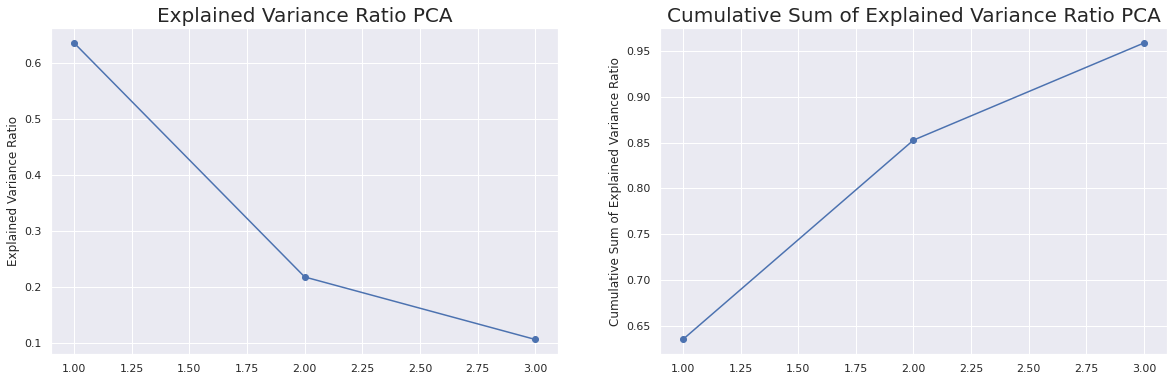

In [127]:
pca = PCA(n_components=.95).fit(normalized_x_train)

fig, ax = plt.subplots(ncols=2, figsize=(20,6))
ax1, ax2 = ax.ravel()

ratio = pca.explained_variance_ratio_
ax1.plot(range(1,len(ratio)+1), ratio, 'o-')
ax1.set_title('Explained Variance Ratio PCA', fontsize=20)
ax1.set_ylabel('Explained Variance Ratio')

ratio = pca.explained_variance_ratio_
ax2.plot(range(1,len(ratio)+1), np.cumsum(ratio), 'o-')
ax2.set_title('Cumulative Sum of Explained Variance Ratio PCA', fontsize=20)
ax2.set_ylabel('Cumulative Sum of Explained Variance Ratio');

In [128]:
x_train_pca = pca.transform(normalized_x_train)
x_test_pca = pca.transform(normalized_x_test)

In [129]:
LR = LogisticRegression(**best_params)
logreg_model_pca = LR.fit(x_train_pca, y_train)

In [130]:
y_preds_train_pca = logreg_model_pca.predict(x_train_pca)
y_preds_test_pca = logreg_model_pca.predict(x_test_pca)

In [131]:
# Evaluation
print('Training Set Score (8 PCs): {}'.format(accuracy_score(y_train, y_preds_train_pca)))
print('Test Set Score (8 PCs): {}\n'.format(accuracy_score(y_test, y_preds_test_pca)))

print('Training Set Score (full dataset): {}'.format(full_logreg_score_train))
print('Test Set Score (full dataset): {}'.format(full_logreg_score_test))

Training Set Score (8 PCs): 1.0
Test Set Score (8 PCs): 1.0

Training Set Score (full dataset): 1.0
Test Set Score (full dataset): 1.0


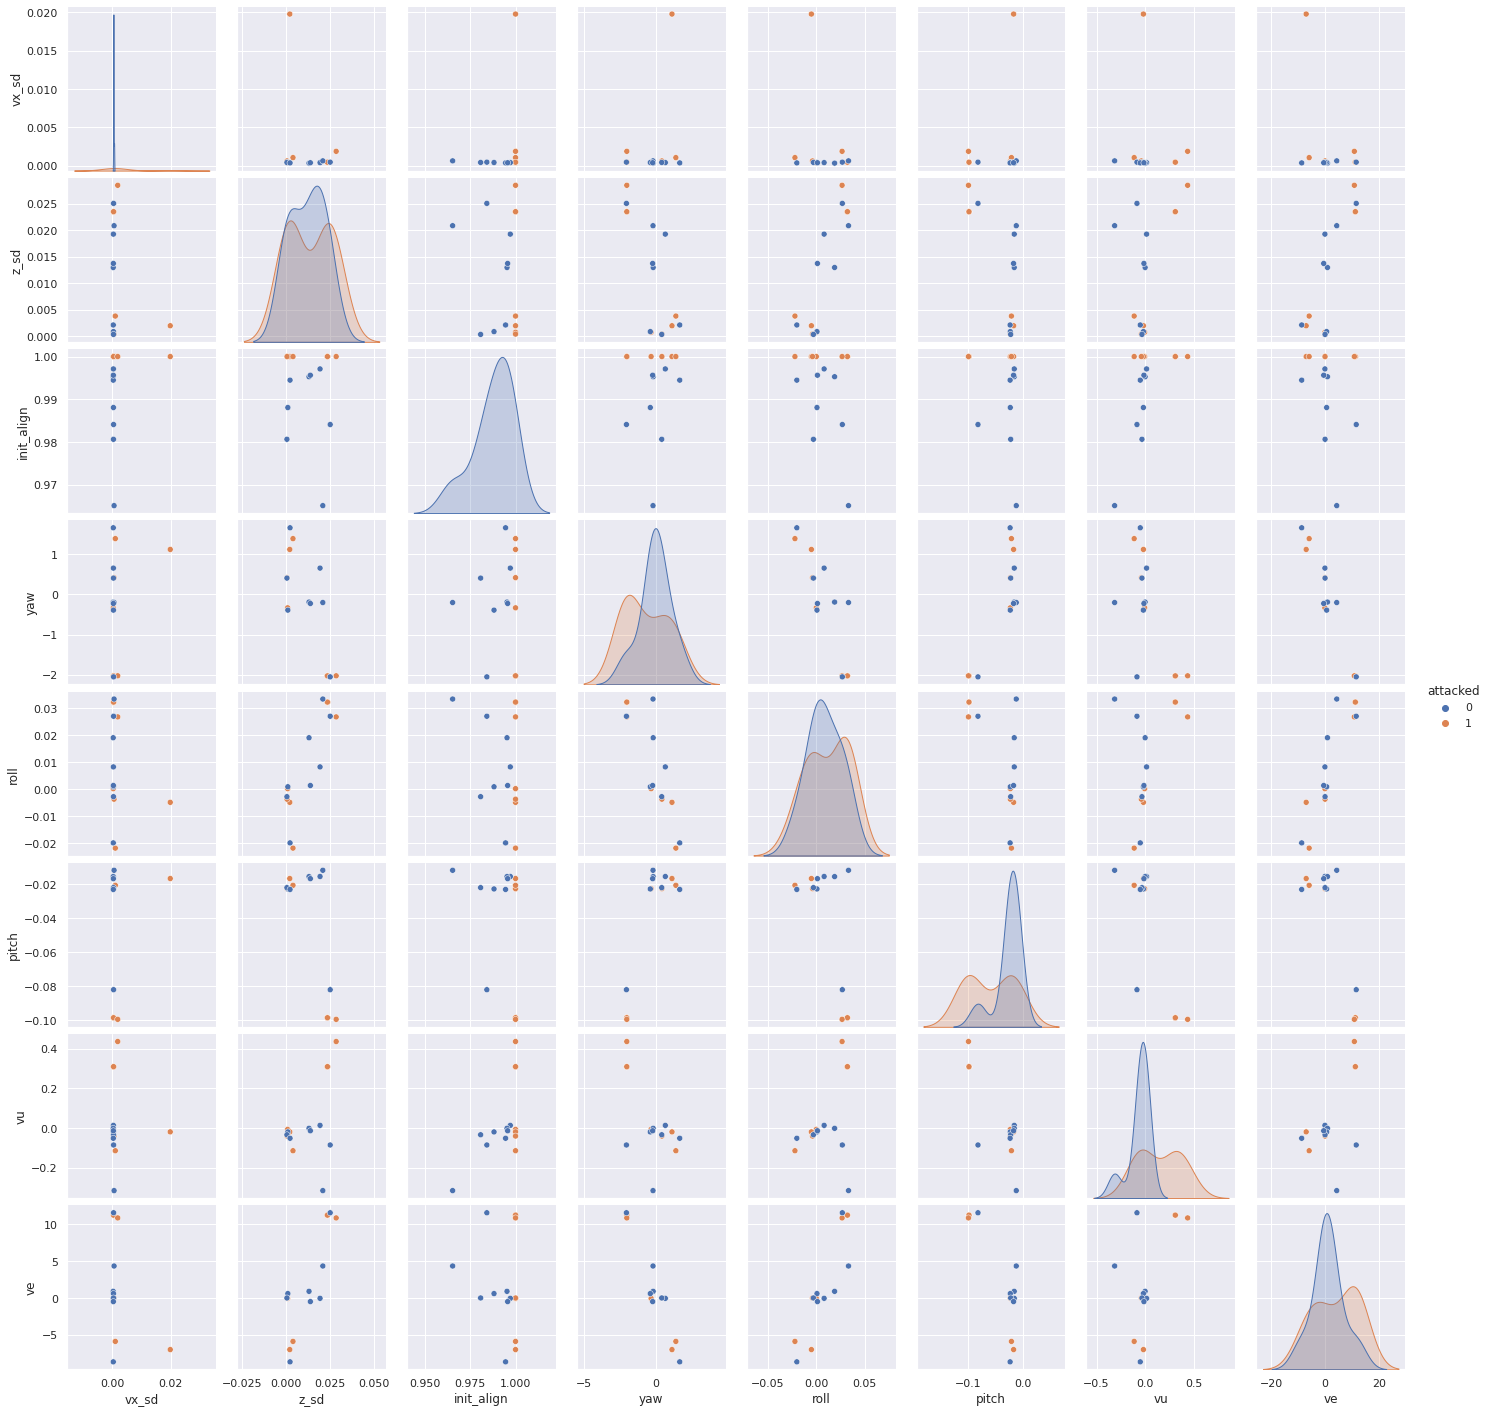

In [132]:
sns.pairplot(final_df, hue="attacked")

In [216]:
plt.show()